In [86]:
from db import db, query, query_list
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [87]:
import scipy.stats as st

In [88]:
sns.set_style('darkgrid')

In [89]:
df = query('SELECT * FROM beers_clean')

### Initial EDA

In [90]:
# Missing Values
df.isna().sum()

name                    0
beer_url                0
abv                    74
price                 263
bar_url                 0
size                  307
kind                   17
establishment_type    419
bar_name                0
county_name             0
beer_category          95
origin_zone           318
dtype: int64

In [91]:
df.describe()

,abv,price,size
count,7763.000000,7574.000000,7530.000000
mean,6.316263,9.554831,13.823592
std,2.046017,7.429275,3.563597
min,0.000000,0.550000,1.000000
25%,5.000000,7.000000,12.000000
50%,5.750000,8.000000,12.000000
75%,7.000000,10.000000,16.000000
max,29.000000,350.000000,25.400000


## Quantitative Variables

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


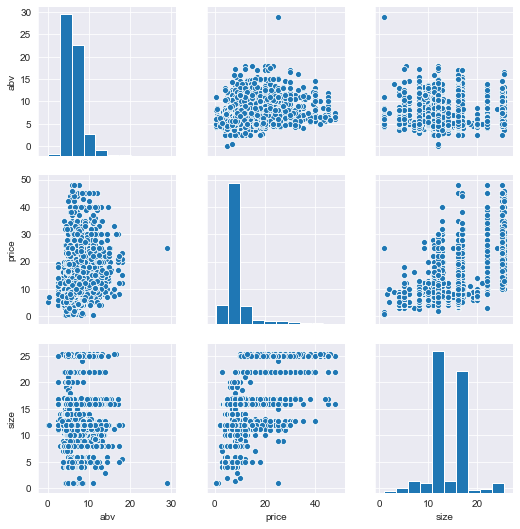

In [92]:
sns.pairplot(df[df.price < 50])

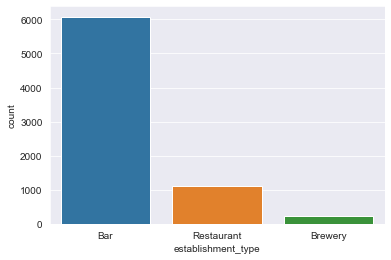

In [93]:
sns.countplot(x = 'establishment_type', data = df)

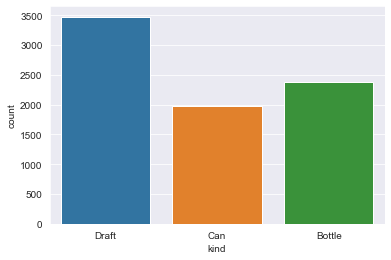

In [94]:
sns.countplot(x = 'kind', data = df)

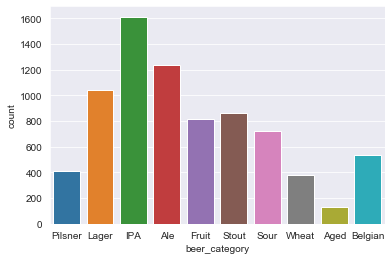

In [95]:
sns.countplot(x = 'beer_category', data = df)

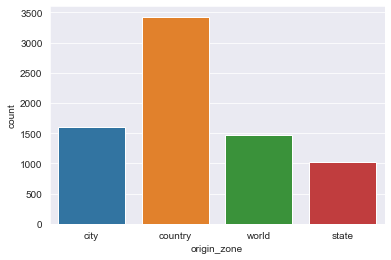

In [96]:
sns.countplot(x = 'origin_zone', data = df)

## Are certain beer styles more popular in each borough?

### Chi-square test for independence

##### H0: Borough has no effect on the popularity of a beer style.

##### Ha: (Style) IPAs are more popular in (borough) Brooklyn.

In [97]:
# Exclude the bronx because it has not enough data
test1_data = df.loc[df.county_name != 'Bronx',['county_name', 'beer_category']].dropna()
test1_table = test1_data.pivot_table(index = 'county_name', columns = 'beer_category', aggfunc = len)
test1_table

beer_category,Aged,Ale,Belgian,Fruit,IPA,Lager,Pilsner,Sour,Stout,Wheat
county_name,,,,,,,,,,
Kings,37,433,134,254,476,306,129,273,280,101
New York,68,589,324,394,870,435,202,362,417,209
Queens,12,130,47,95,186,180,54,56,112,47
Richmond,11,79,33,67,76,124,23,30,48,22


In [98]:
chi2, p, dof, ex = st.chi2_contingency(test1_table)
print(f'chi2 : {chi2}\np    : {p}\ndof  : {dof}')

chi2 : 173.65398219919535
p    : 2.2809906367857478e-23
dof  : 27


With a high X^2 value, we know there is a lot of difference between our observed counts and the counts that we would expect if our H0 was true (that there is no difference in beer style popularity between NYC boroughs).

With a low p value, the probability of a X^2 value of this size happening by chance is pretty small (just about 0). Therefore, we can reject the H0 and assume there is a statistically significant correlation between borough and beer style popularity.

In [99]:
# Look at the frequency table
row_freq = test1_table.apply(lambda s : s/s.sum(), axis = 'columns')
round(row_freq*100,1)

beer_category,Aged,Ale,Belgian,Fruit,IPA,Lager,Pilsner,Sour,Stout,Wheat
county_name,,,,,,,,,,
Kings,1.5,17.9,5.5,10.5,19.6,12.6,5.3,11.3,11.6,4.2
New York,1.8,15.2,8.4,10.2,22.5,11.2,5.2,9.4,10.8,5.4
Queens,1.3,14.1,5.1,10.3,20.2,19.6,5.9,6.1,12.2,5.1
Richmond,2.1,15.4,6.4,13.1,14.8,24.2,4.5,5.8,9.4,4.3


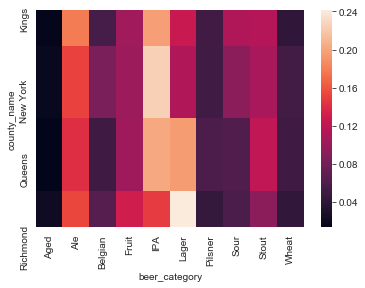

In [100]:
sns.heatmap(row_freq)

#### Does price (per oz) increase as ABV increases?

In [101]:
df['price_per_oz'] = df['size']/df['price']

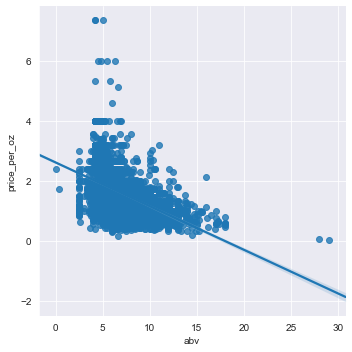

In [102]:
sns.lmplot('abv', 'price_per_oz', data=df)

In [103]:
temp_df = df[df.abv < 20]

In [104]:
df.describe()

,abv,price,size,price_per_oz
count,7763.000000,7574.000000,7530.000000,7450.000000
mean,6.316263,9.554831,13.823592,1.686507
std,2.046017,7.429275,3.563597,0.619130
min,0.000000,0.550000,1.000000,0.040000
25%,5.000000,7.000000,12.000000,1.333333
50%,5.750000,8.000000,12.000000,1.714286
75%,7.000000,10.000000,16.000000,2.000000
max,29.000000,350.000000,25.400000,7.333333


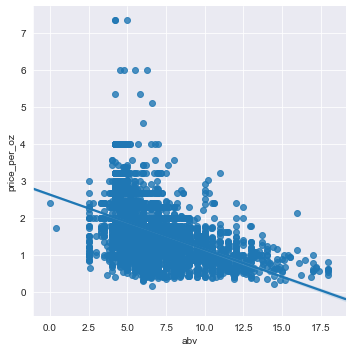

In [105]:
sns.lmplot('abv', 'price_per_oz', data=temp_df)

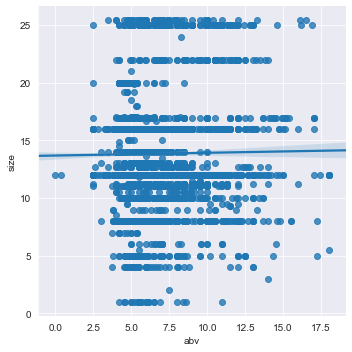

In [106]:
sns.lmplot('abv', 'size', data=temp_df)

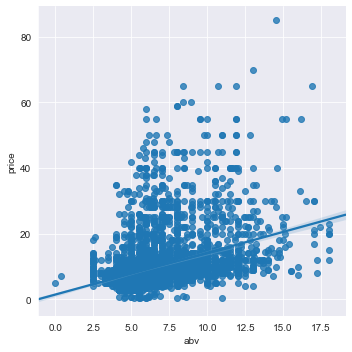

In [107]:
sns.lmplot('abv', 'price', data=temp_df)

In [108]:
temp_df['alcohol_content'] = temp_df['abv']*temp_df['size']/100

/Users/rcharan/anaconda3/envs/learn-env/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


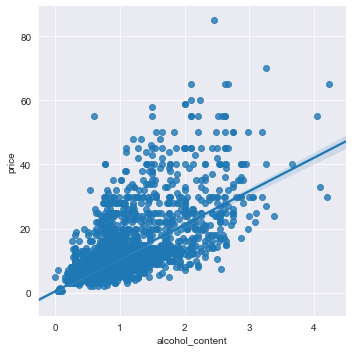

In [109]:
sns.lmplot('alcohol_content', 'price', data=temp_df)

In [110]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

results = smf.ols('price ~ alcohol_content', data=temp_df, ).fit()

In [111]:
sm.stats.anova_lm(results, typ = 2)

,sum_sq,df,F,PR(>F)
alcohol_content,125912.621957,1.0,5541.006519,0.0
Residual,167656.060611,7378.0,NaN,NaN


In [112]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.429
Method:                 Least Squares   F-statistic:                     5541.
Date:                Thu, 14 Nov 2019   Prob (F-statistic):               0.00
Time:                        18:17:13   Log-Likelihood:                -21996.
No. Observations:                7380   AIC:                         4.400e+04
Df Residuals:                    7378   BIC:                         4.401e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.4122      0.135      3.064      0.002       0.149       0.676
alcohol_content    10.4288      0.140     74.438      0.000      10.154      10.703
==============================================================================
Omnibus:                     5561.329   Durbin-Watson:                   1.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           140532.689
Skew:                           3.396   Prob(JB):                         0.00
Kurtosis:                      23.270   Cond. No.                         4.64
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Locality of brewer


In [114]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7837 entries, 0 to 7836
Data columns (total 13 columns):
name                  7837 non-null object
beer_url              7837 non-null object
abv                   7763 non-null float64
price                 7574 non-null float64
bar_url               7837 non-null object
size                  7530 non-null float64
kind                  7820 non-null object
establishment_type    7418 non-null object
bar_name              7837 non-null object
county_name           7837 non-null object
beer_category         7742 non-null object
origin_zone           7519 non-null object
price_per_oz          7450 non-null float64
dtypes: float64(4), object(9)
memory usage: 796.1+ KB


In [115]:
df.groupby('origin_zone')['price'].mean()

origin_zone
city        8.933438
country     9.671036
state       8.488881
world      10.473456
Name: price, dtype: float64

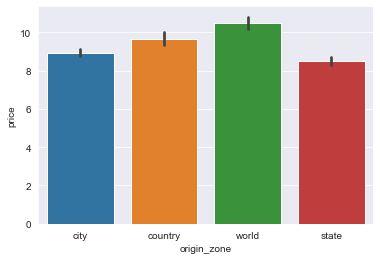

In [116]:
sns.barplot(x = 'origin_zone', y = 'price', data = df)

In [117]:
results = smf.ols('price ~ origin_zone', data=df).fit()

In [121]:
sm.stats.anova_lm(results, typ = 2)

,sum_sq,df,F,PR(>F)
origin_zone,2960.653596,3.0,18.012789,1.212483e-11
Residual,398199.129356,7268.0,NaN,NaN


In [119]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     18.01
Date:                Thu, 14 Nov 2019   Prob (F-statistic):           1.21e-11
Time:                        18:19:23   Log-Likelihood:                -24873.
No. Observations:                7272   AIC:                         4.975e+04
Df Residuals:                    7268   BIC:                         4.978e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  8.9334      0.189     47.255      0.000       8.563       9.304
origin_zone[T.country]     0.7376      0.229      3.226      0.001       0.289       1.186
origin_zone[T.state]      -0.4446      0.302     -1.470      0.142      -1.037       0.148
origin_zone[T.world]       1.5400      0.271      5.673      0.000       1.008       2.072
==============================================================================
Omnibus:                    14579.053   Durbin-Watson:                   1.285
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        118762112.063
Skew:                          15.822   Prob(JB):                         0.00
Kurtosis:                     628.262   Cond. No.                         5.47
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""